In [ ]:
# ✅ STEP 1: Install necessary libraries (with version specified)
import os
os.environ['PIP_DISABLE_PIP_VERSION_CHECK'] = '1'
# Disable wandb completely
os.environ['WANDB_DISABLED'] = 'true'
!pip install --quiet "transformers>=4.30.0" datasets

# ✅ STEP 2: Imports
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from tqdm import tqdm
import pickle
import time
import gc

# ✅ STEP 3: Check GPU and set memory efficiency settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

if torch.cuda.is_available():
    # Free up memory before starting
    torch.cuda.empty_cache()

# ✅ STEP 4: Load dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update this path to your actual CSV file inside Drive
print("Loading dataset...")
try:
    df = pd.read_csv("/content/drive/MyDrive/selected_features_dataset.csv", low_memory=False)
    print(f"✅ Dataset loaded successfully with {len(df)} rows and {df.shape[1]} columns")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("Please check the path to your CSV file")

# ✅ STEP 5: Define feature columns
feature_cols = ['Date', 'Timestamp', 'Scr_port', 'Protocol', 'Duration', 'Scr_bytes', 'Conn_state',
                'Des_pkts', 'Des_ip_bytes', 'anomaly_alert', 'byte_rate', 'Scr_packts_ratio',
                'Des_bytes_ratio', 'Avg_user_time', 'Std_nice_time', 'Avg_iowait_time',
                'Std_iowait_time', 'Avg_ideal_time', 'Std_ideal_time', 'Std_tps', 'Avg_rtps',
                'Std_rtps', 'Avg_wtps', 'Std_ldavg_1', 'Std_kbmemused', 'Std_num_proc/s',
                'std_num_cswch/s']

# ✅ STEP 6: Convert row into text (optimized)
def convert_to_text(row):
    return " ".join([str(val) for val in row.values])

# ✅ STEP 7: Memory-efficient batch tokenization function
def batch_tokenize(texts, tokenizer, batch_size=10000, max_length=96):
    all_encodings = {'input_ids': [], 'attention_mask': []}
    total_batches = (len(texts) + batch_size - 1) // batch_size

    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing", total=total_batches):
        batch_texts = texts[i:i+batch_size]
        batch_enc = tokenizer(batch_texts, truncation=True, padding=True, max_length=max_length)
        all_encodings['input_ids'].extend(batch_enc['input_ids'])
        all_encodings['attention_mask'].extend(batch_enc['attention_mask'])

        # Force garbage collection after each batch
        if i % (batch_size * 3) == 0 and i > 0:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    return all_encodings

# ✅ STEP 8: Custom Dataset class
class TabularTextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# ✅ STEP 9: Super minimal DistilBERT training function
def train_distilbert_simple(target_col, sample_rows=None):
    """Ultra simple version with minimal parameters"""
    start_time = time.time()
    print(f"\n📊 Training DistilBERT on: {target_col}")
    print(f"⏱️ Started at: {time.strftime('%H:%M:%S')}")

    try:
        # Basic data prep
        print("Preparing data...")
        df_clean = df.dropna(subset=feature_cols + [target_col])
        if sample_rows and sample_rows < len(df_clean):
            df_clean = df_clean.sample(sample_rows, random_state=42).reset_index(drop=True)
        print(f"Using {len(df_clean)} samples")

        # Convert to text
        print("Converting features to text...")
        df_clean["text"] = df_clean[feature_cols].apply(convert_to_text, axis=1)

        # Encode labels
        print("Encoding labels...")
        label_enc = LabelEncoder()
        y = label_enc.fit_transform(df_clean[target_col])
        num_labels = len(set(y))
        print(f"Number of classes: {num_labels}")

        # Tokenize
        print("Tokenizing text...")
        tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        encodings = batch_tokenize(df_clean["text"].tolist(), tokenizer, max_length=96)

        # Split data
        print("Splitting data...")
        X_train, X_val, y_train, y_val = train_test_split(
            range(len(df_clean)), y, test_size=0.2, random_state=42)

        train_encodings = {key: [val[i] for i in X_train] for key, val in encodings.items()}
        val_encodings = {key: [val[i] for i in X_val] for key, val in encodings.items()}

        train_dataset = TabularTextDataset(train_encodings, [y[i] for i in X_train])
        val_dataset = TabularTextDataset(val_encodings, [y[i] for i in X_val])

        # Load model
        print("Loading model...")
        model = DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            num_labels=num_labels
        ).to(device)

        # Minimal training args with wandb disabled
        print("Setting up training arguments...")
        training_args = TrainingArguments(
            output_dir=f"./results_{target_col}",
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64,
            logging_dir=f"./logs_{target_col}",
            logging_steps=100,
            report_to="none",  # Explicitly disable reporting
            run_name=f"distilbert_{target_col}_{int(time.time())}"  # Unique run name
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        # Train
        print("Starting training...")
        training_start = time.time()
        trainer.train()
        training_time = (time.time() - training_start) / 60
        print(f"Training completed in {training_time:.2f} minutes")

        # Evaluate
        print("Evaluating model...")
        eval_result = trainer.evaluate()
        print(f"Evaluation Results: {eval_result}")

        # Save
        model_path = f"/content/drive/MyDrive/distilbert_{target_col}_model"
        print(f"Saving model to {model_path}")
        model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)

        # Save label encoder
        with open(f"{model_path}/label_encoder.pkl", "wb") as f:
            pickle.dump(label_enc, f)

        total_time = (time.time() - start_time) / 60
        print(f"✅ Complete process finished in {total_time:.2f} minutes")
        return model_path

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# ✅ STEP 10: Function to clear memory between runs
def clear_memory():
    """Helper function to clear memory between model trainings"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("🧹 Memory cleared")

# Set the value to None for full dataset or a number for testing
SAMPLE_SIZE = 20000  # Use None for full dataset

print("\n==== STARTING DISTILBERT TRAINING WORKFLOW ====")

# Train all three models
model_path_1 = train_distilbert_simple("class1", sample_rows=SAMPLE_SIZE)
clear_memory()

model_path_2 = train_distilbert_simple("class2", sample_rows=SAMPLE_SIZE)
clear_memory()

model_path_3 = train_distilbert_simple("class3", sample_rows=SAMPLE_SIZE)
clear_memory()

print("\n==== TRAINING COMPLETE ====")
print("Model paths:")
print(f"- class1: {model_path_1}")
print(f"- class2: {model_path_2}")
print(f"- class3: {model_path_3}")

✅ Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading dataset...
✅ Dataset loaded successfully with 820834 rows and 30 columns

==== STARTING DISTILBERT TRAINING WORKFLOW ====

📊 Training DistilBERT on: class1
⏱️ Started at: 05:36:57
Preparing data...
Using 20000 samples
Converting features to text...
Encoding labels...
Number of classes: 18
Tokenizing text...


Tokenizing: 100%|██████████| 2/2 [00:19<00:00,  9.69s/it]


Splitting data...
Loading model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setting up training arguments...
Starting training...


Step,Training Loss
100,1.350000
200,0.510400
300,0.275700
400,0.238800
500,0.231300
600,0.149000
700,0.199600
800,0.150800
900,0.096200
1000,0.120600


Training completed in 7.45 minutes
Evaluating model...


Evaluation Results: {'eval_loss': 0.04437680169939995, 'eval_runtime': 10.9728, 'eval_samples_per_second': 364.537, 'eval_steps_per_second': 5.741, 'epoch': 3.0}
Saving model to /content/drive/MyDrive/distilbert_class1_model
✅ Complete process finished in 8.02 minutes
🧹 Memory cleared

📊 Training DistilBERT on: class2
⏱️ Started at: 05:44:59
Preparing data...
Using 20000 samples
Converting features to text...
Encoding labels...
Number of classes: 10
Tokenizing text...


Tokenizing: 100%|██████████| 2/2 [00:19<00:00,  9.77s/it]


Splitting data...
Loading model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setting up training arguments...
Starting training...


Step,Training Loss
100,0.896200
200,0.333400
300,0.249900
400,0.211600
500,0.171100
600,0.141500
700,0.142300
800,0.118000
900,0.117700
1000,0.093600


Training completed in 8.00 minutes
Evaluating model...


Evaluation Results: {'eval_loss': 0.04019863158464432, 'eval_runtime': 10.6649, 'eval_samples_per_second': 375.063, 'eval_steps_per_second': 5.907, 'epoch': 3.0}
Saving model to /content/drive/MyDrive/distilbert_class2_model
✅ Complete process finished in 8.58 minutes
🧹 Memory cleared

📊 Training DistilBERT on: class3
⏱️ Started at: 05:53:35
Preparing data...
Using 20000 samples
Converting features to text...
Encoding labels...
Number of classes: 2
Tokenizing text...


Tokenizing: 100%|██████████| 2/2 [00:19<00:00,  9.79s/it]


Splitting data...
Loading model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setting up training arguments...
Starting training...


Step,Training Loss
100,0.501800
200,0.277400
300,0.238900
400,0.209200
500,0.197600
600,0.152900
700,0.153900
800,0.127800
900,0.114000
1000,0.101400


Training completed in 7.86 minutes
Evaluating model...


Evaluation Results: {'eval_loss': 0.044079769402742386, 'eval_runtime': 10.5805, 'eval_samples_per_second': 378.053, 'eval_steps_per_second': 5.954, 'epoch': 3.0}
Saving model to /content/drive/MyDrive/distilbert_class3_model
✅ Complete process finished in 8.43 minutes
🧹 Memory cleared

==== TRAINING COMPLETE ====
Model paths:
- class1: /content/drive/MyDrive/distilbert_class1_model
- class2: /content/drive/MyDrive/distilbert_class2_model
- class3: /content/drive/MyDrive/distilbert_class3_model



==== STARTING MODEL EVALUATION ====

📊 EVALUATING MODEL FOR: class1
Tokenizing evaluation data...


Tokenizing: 100%|██████████| 1/1 [00:26<00:00, 26.47s/it]


Generating predictions...



----- RESULTS FOR class1 -----
Accuracy: 0.9923
Precision: 0.9918
Recall: 0.9923
F1 Score: 0.9916

Classification Report:
                                precision    recall  f1-score   support

                    BruteForce       1.00      1.00      1.00       584
                           C&C       0.98      0.98      0.98        49
                    Dictionary       0.94      1.00      0.97        33
         Discovering_resources       0.96      1.00      0.98       274
                  Exfiltration       1.00      1.00      1.00       277
          False_data_injection       0.92      1.00      0.96        60
              Generic_scanning       1.00      1.00      1.00       666
MQTT_cloud_broker_subscription       0.98      1.00      0.99       274
                          MitM       0.00      0.00      0.00         3
       Modbus_register_reading       0.99      1.00      0.99        79
                        Normal       0.99      0.99      0.99      5048
            

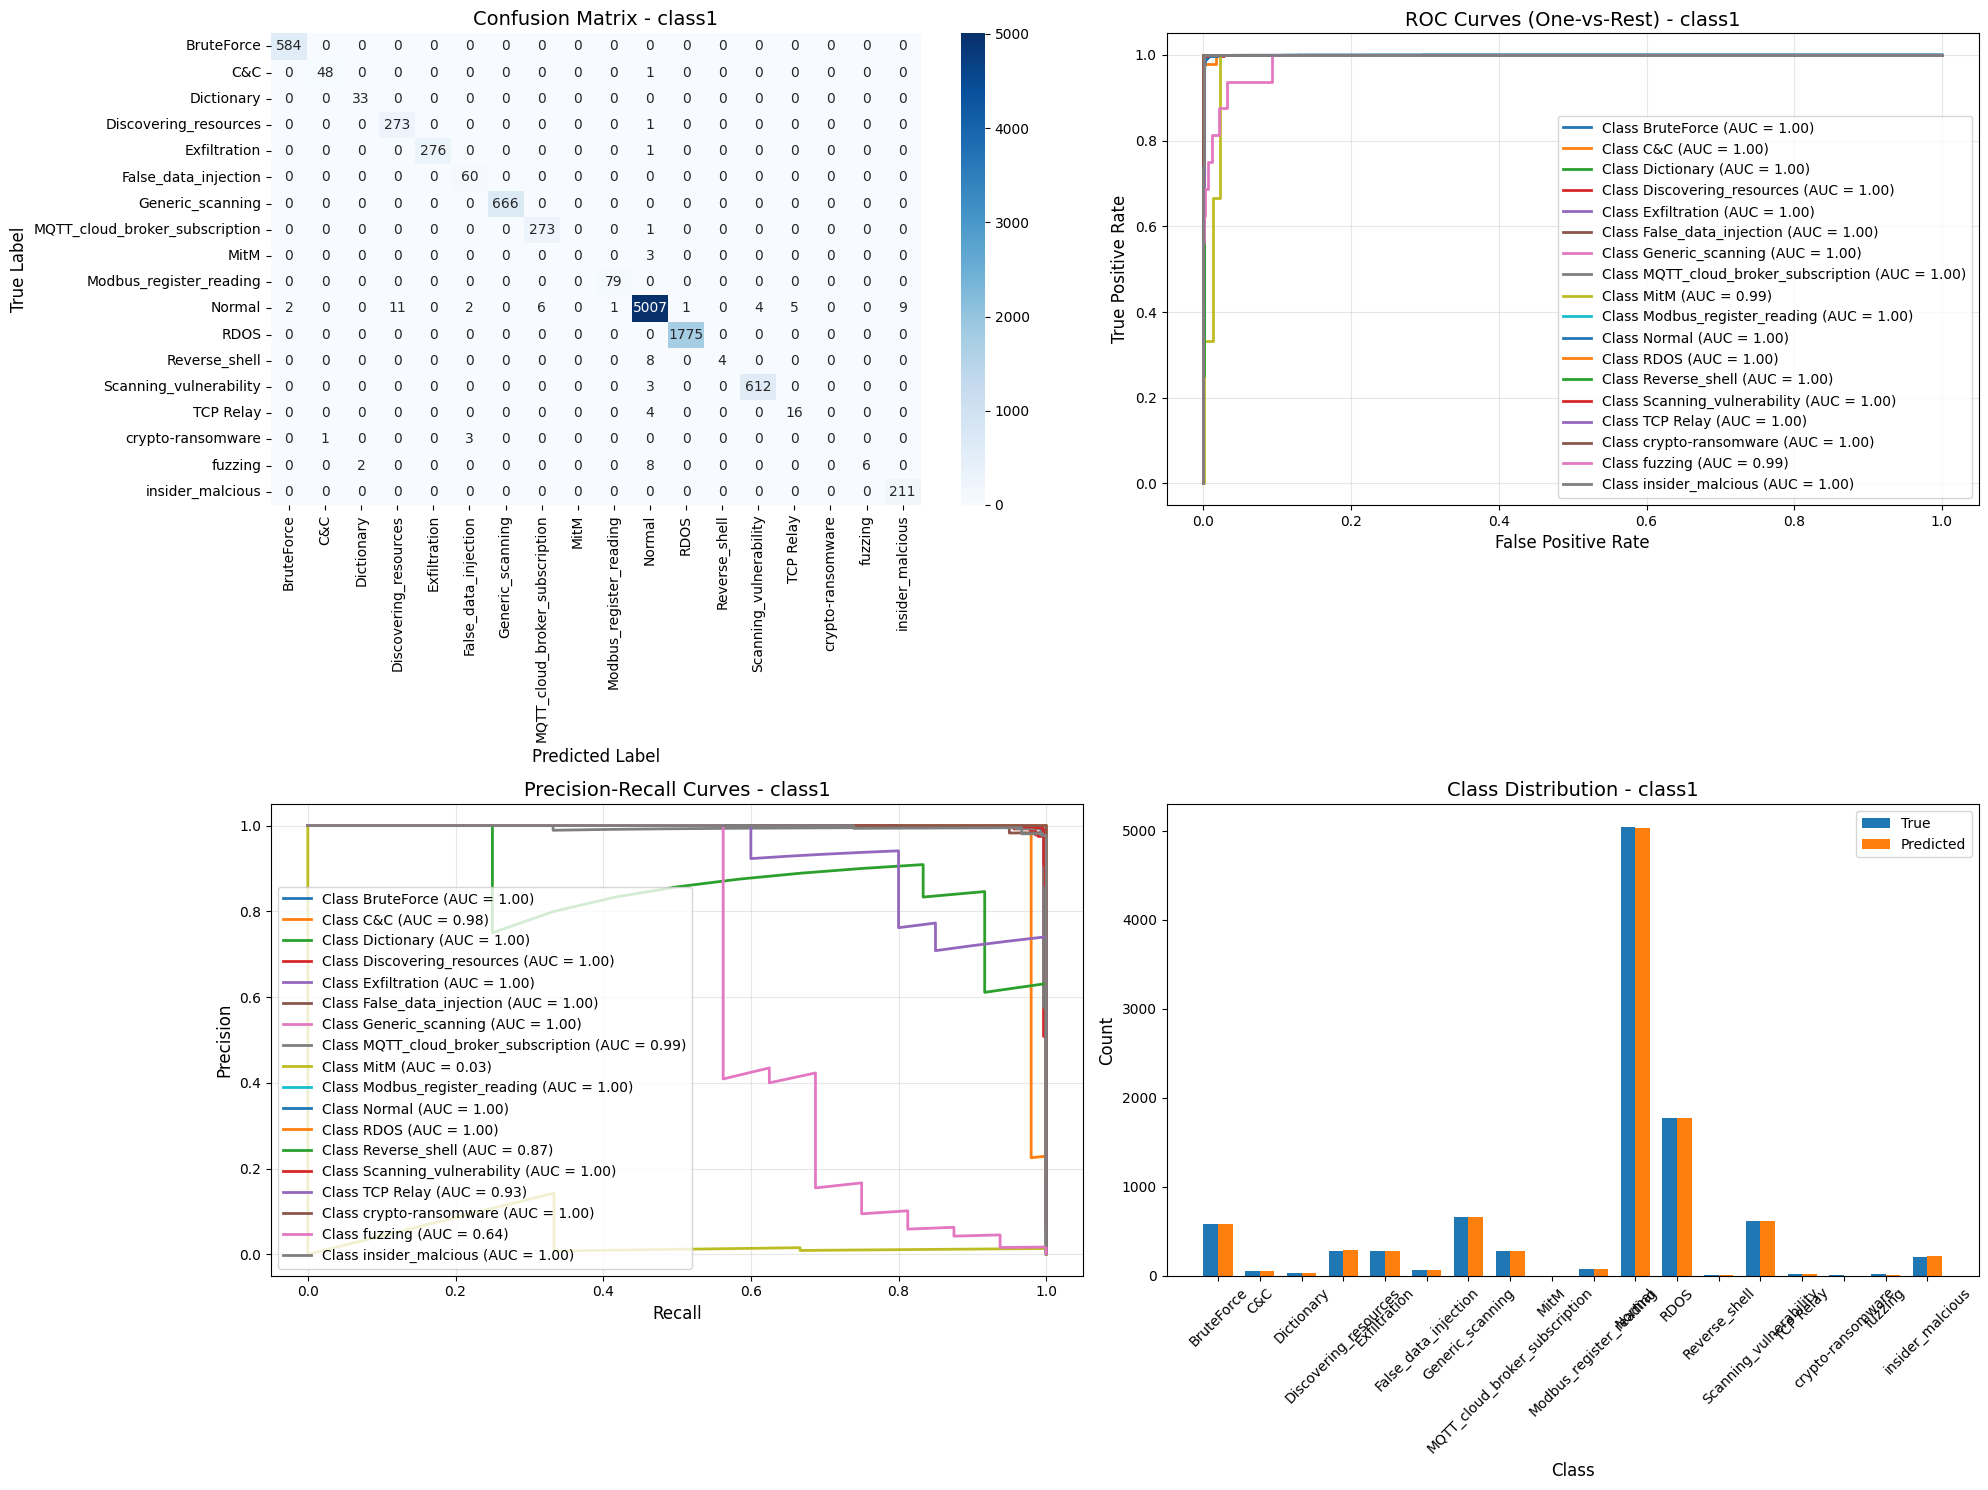

🧹 Memory cleared

📊 EVALUATING MODEL FOR: class2
Tokenizing evaluation data...


Tokenizing: 100%|██████████| 1/1 [00:10<00:00, 10.19s/it]

Generating predictions...



----- RESULTS FOR class2 -----
Accuracy: 0.9917
Precision: 0.9913
Recall: 0.9917
F1 Score: 0.9915

Classification Report:
                   precision    recall  f1-score   support

              C&C       1.00      0.96      0.98        49
     Exfiltration       0.99      1.00      0.99       277
     Exploitation       0.77      0.67      0.71        15
Lateral _movement       0.99      0.95      0.97       373
           Normal       0.99      0.99      0.99      5048
             RDOS       1.00      1.00      1.00      1775
   Reconnaissance       0.99      0.99      0.99      1571
        Tampering       0.98      1.00      0.99        60
    Weaponization       0.99      0.99      0.99       828
crypto-ransomware       0.00      0.00      0.00         4

         accuracy                           0.99     10000
        macro avg       0.87      0.85      0.86     10000
     weighted avg       0.99      0.99      0.99     10000



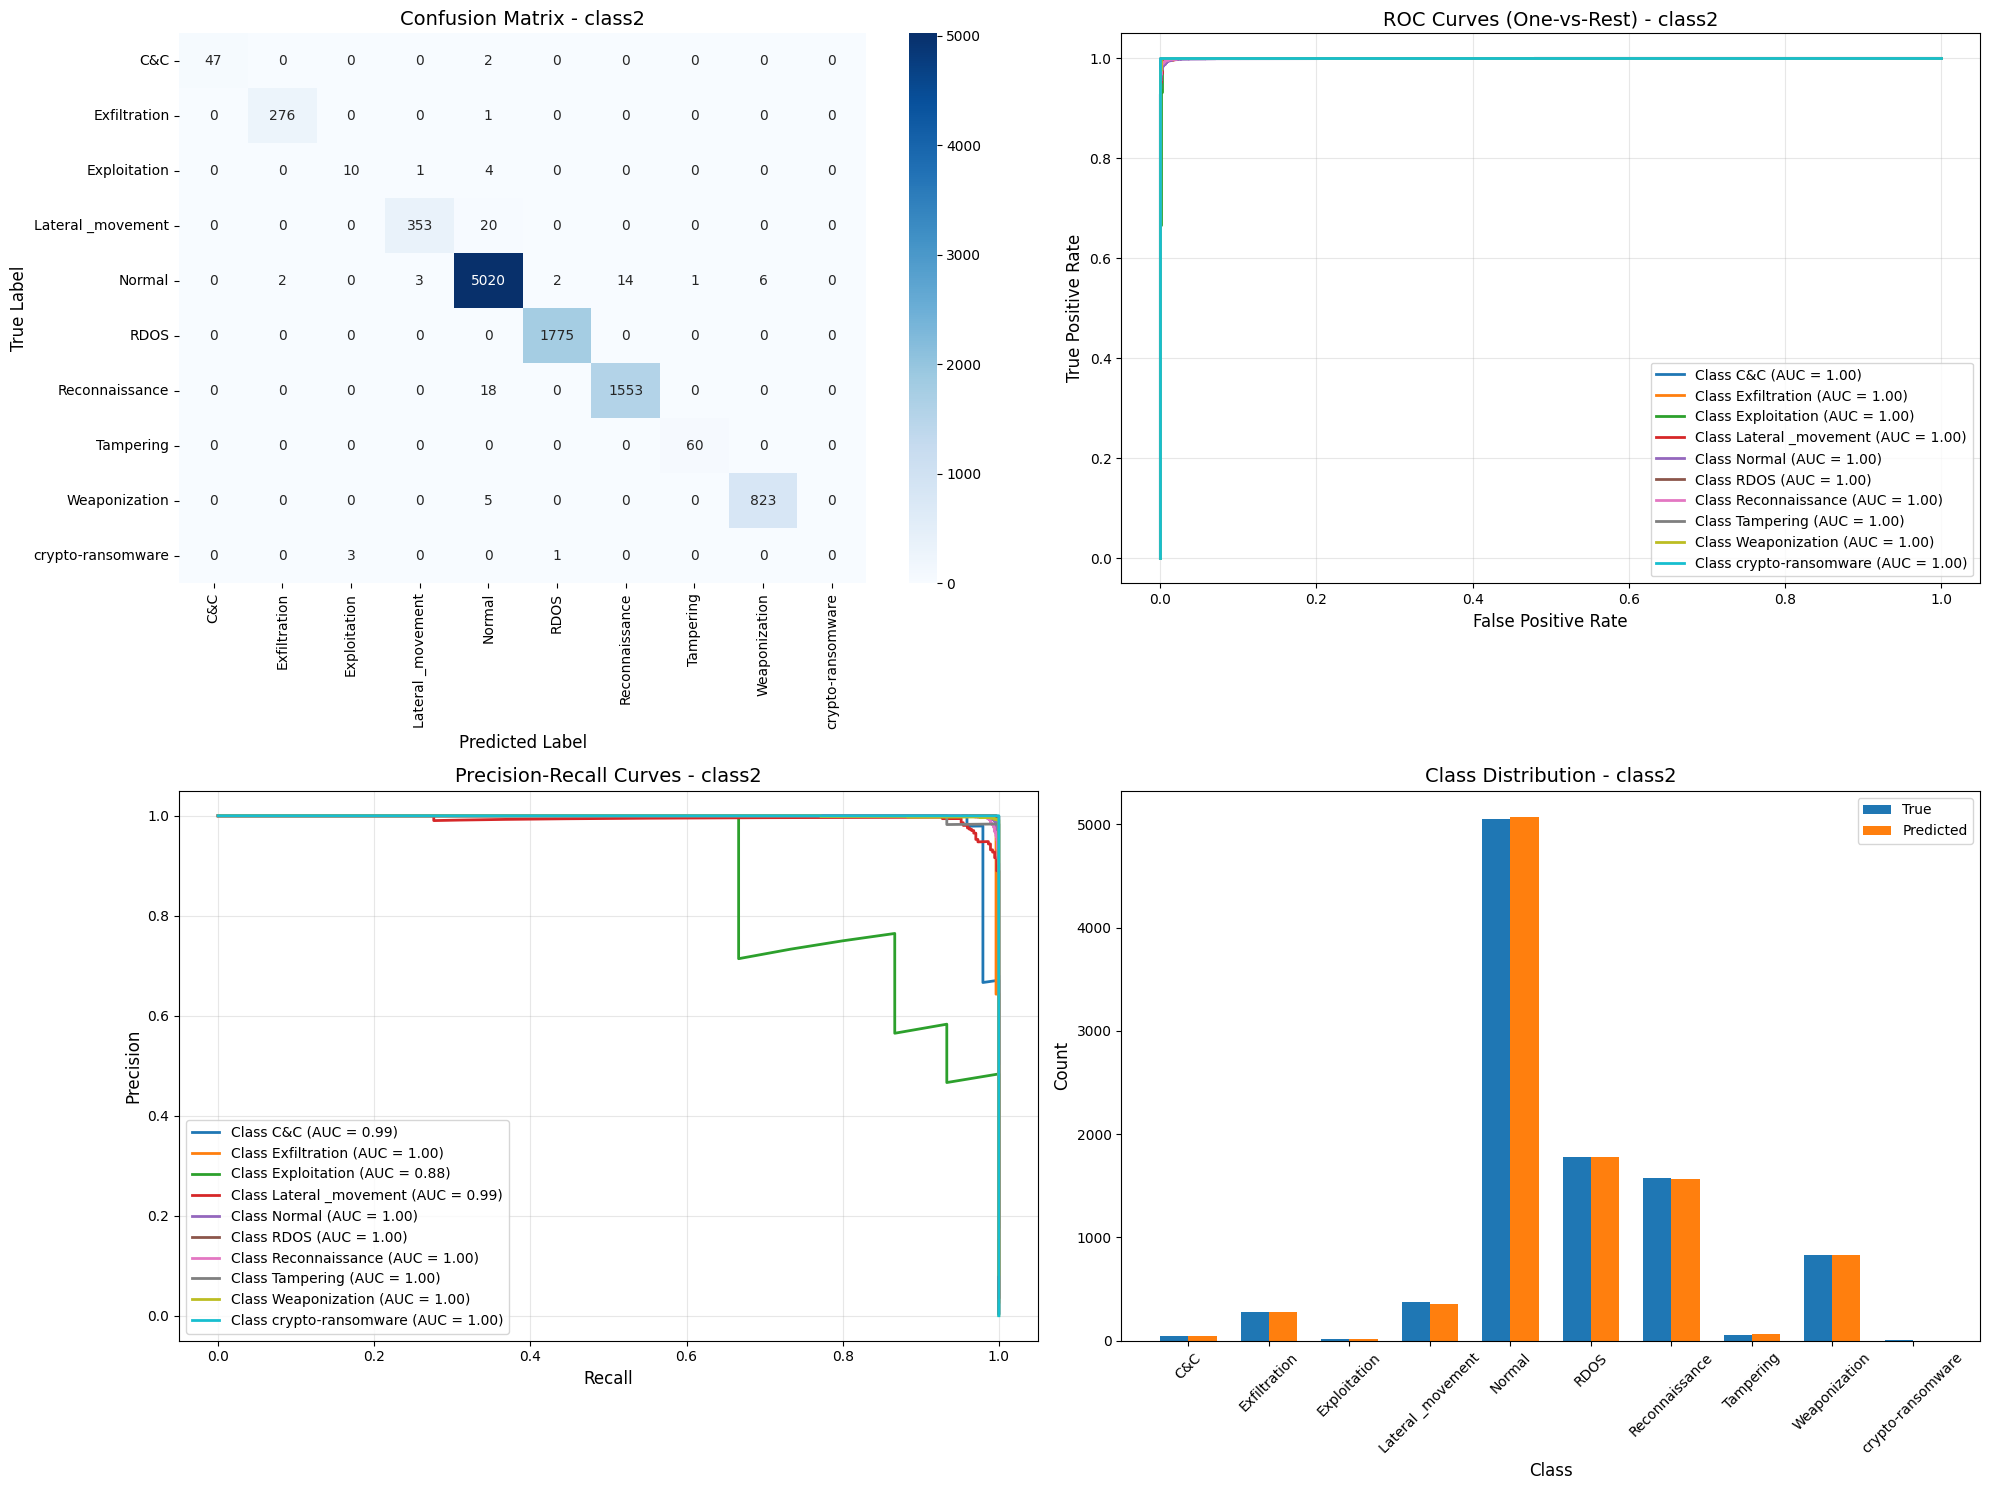

🧹 Memory cleared

📊 EVALUATING MODEL FOR: class3
Tokenizing evaluation data...


Tokenizing: 100%|██████████| 1/1 [00:10<00:00, 10.34s/it]

Generating predictions...



----- RESULTS FOR class3 -----
Accuracy: 0.9921
Precision: 0.9921
Recall: 0.9921
F1 Score: 0.9921

Classification Report:
              precision    recall  f1-score   support

      Attack       0.99      0.99      0.99      4952
      Normal       0.99      0.99      0.99      5048

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



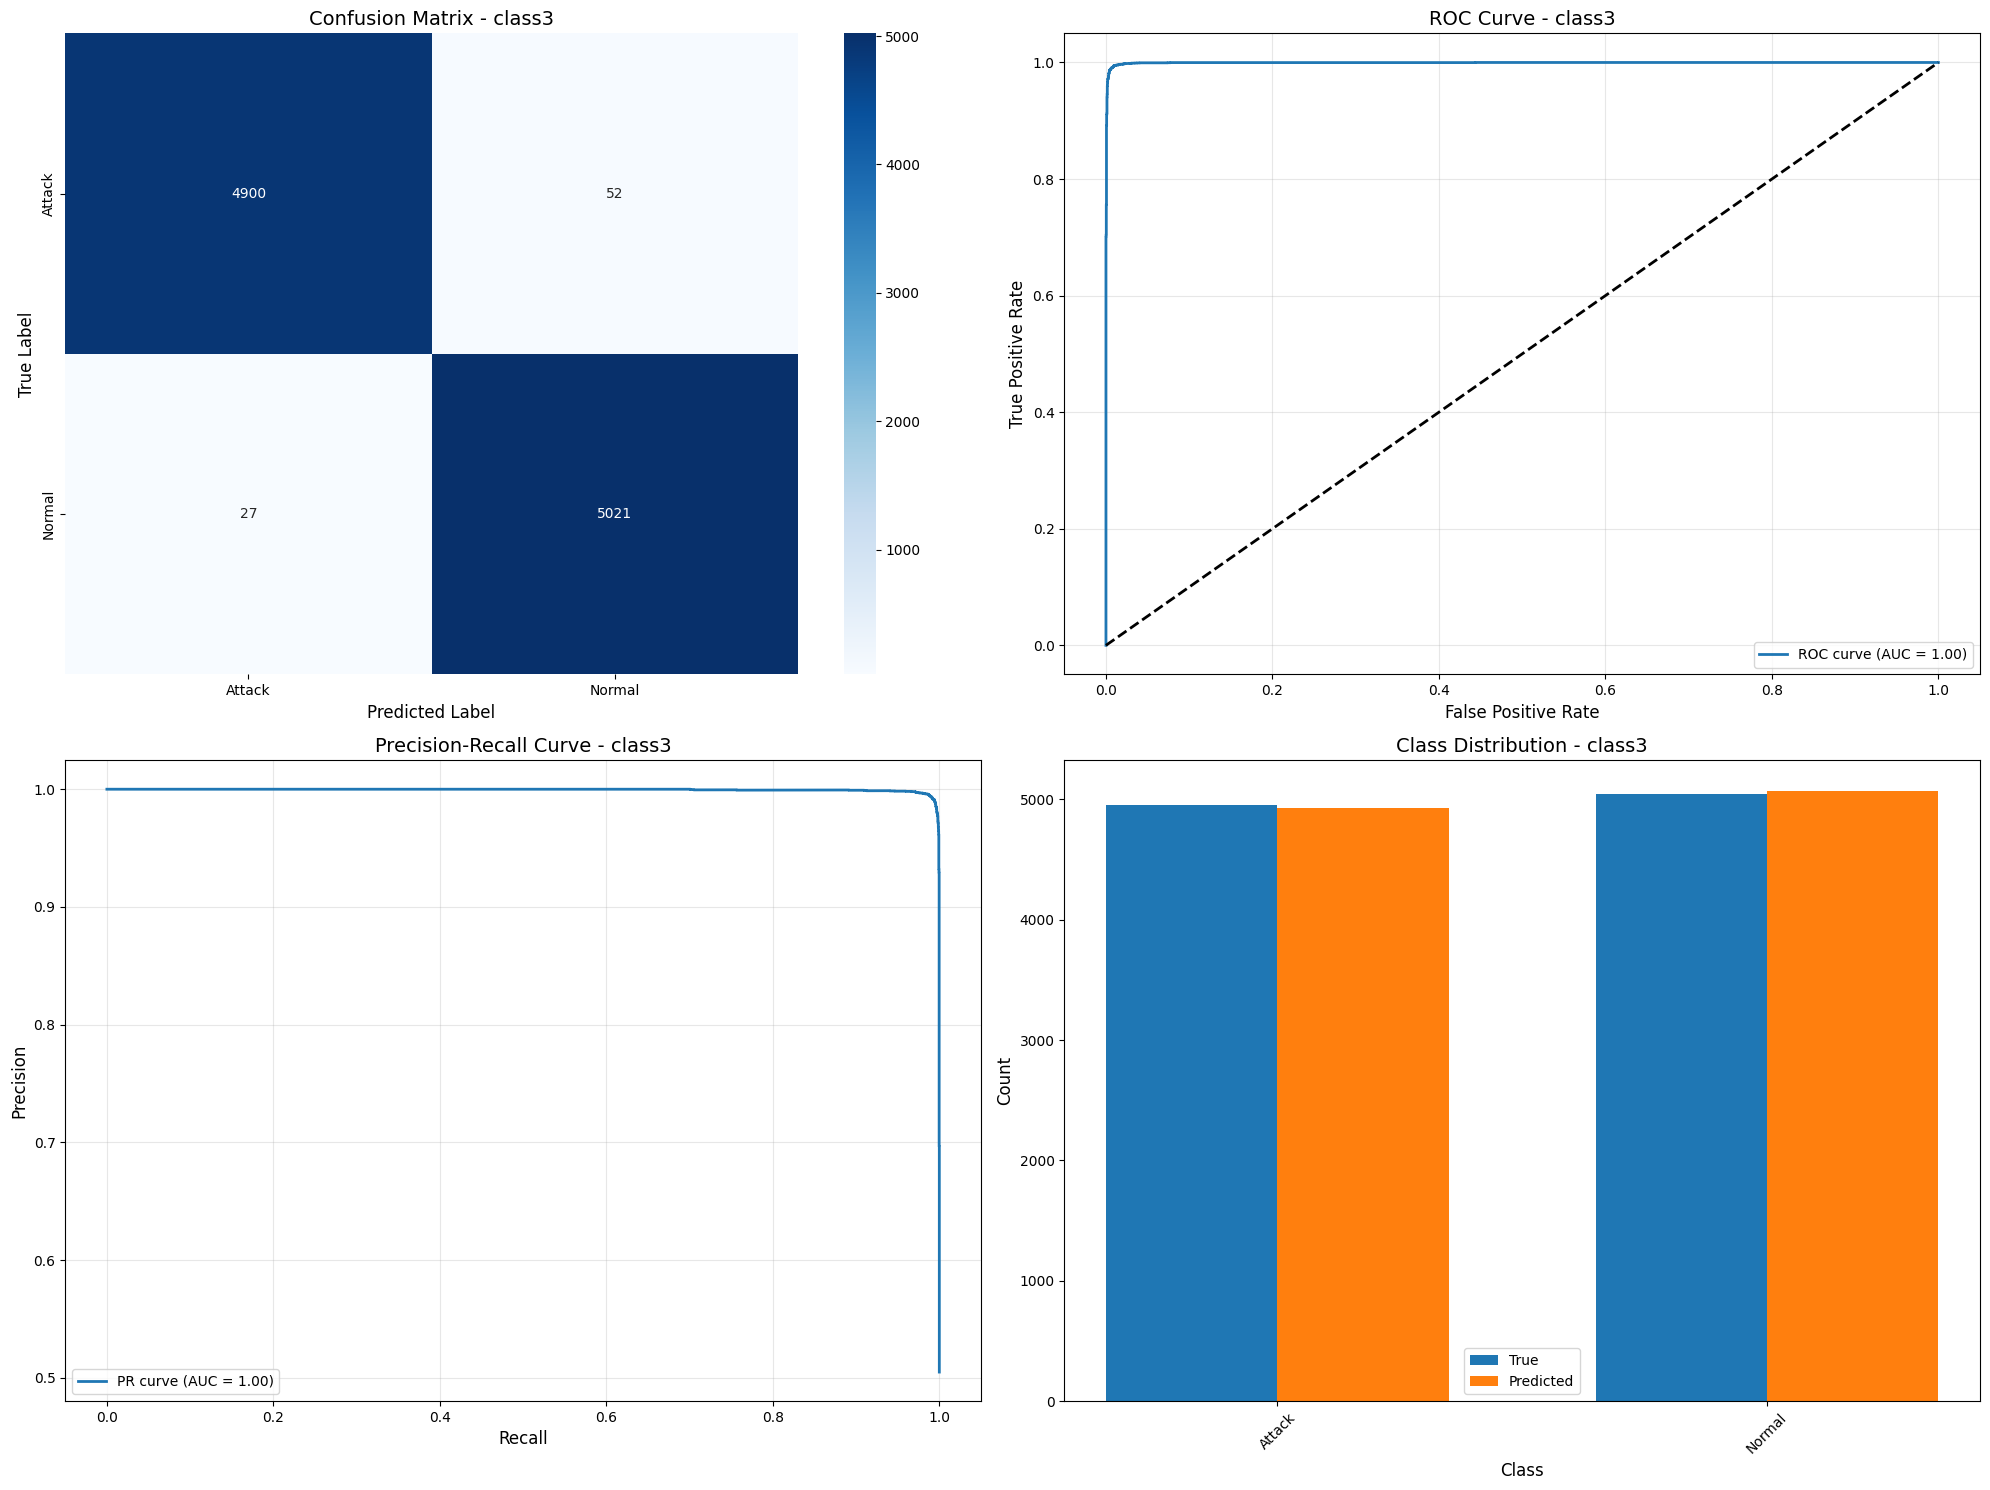

🧹 Memory cleared

==== OVERALL MODEL PERFORMANCE SUMMARY ====
 Model  Accuracy  Precision  Recall  F1 Score
class1    0.9923   0.991756  0.9923  0.991567
class2    0.9917   0.991258  0.9917  0.991451
class3    0.9921   0.992112  0.9921  0.992100


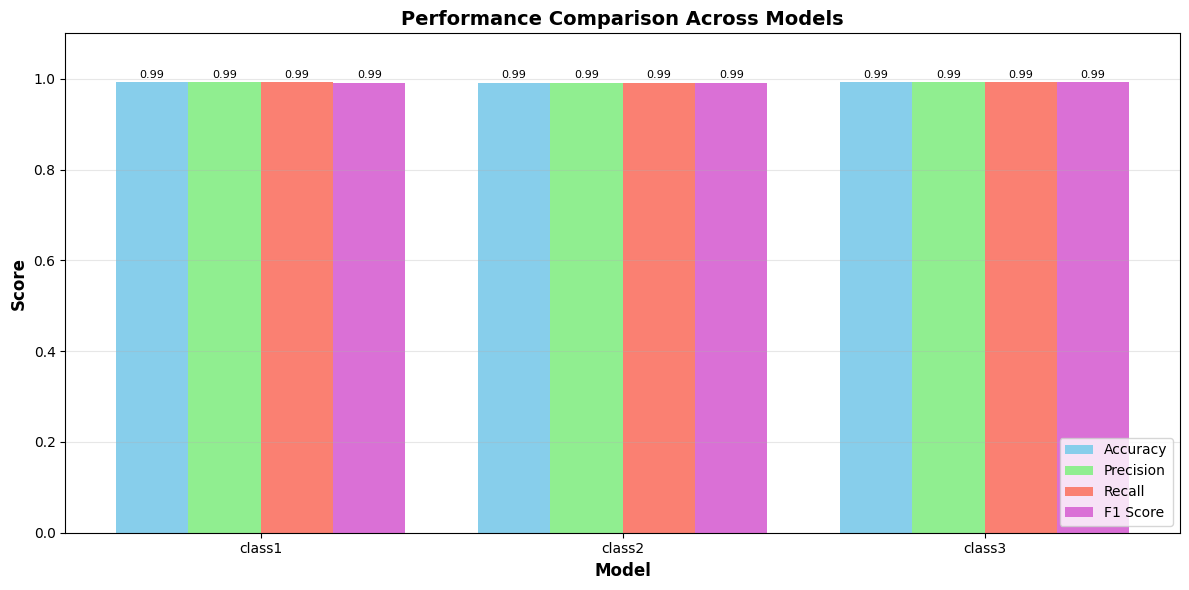


==== EVALUATION COMPLETE ====


In [ ]:
# ✅ STEP 11: Model Evaluation and Visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

def evaluate_model(target_col, model_path, sample_size=None):
    """
    Evaluate a trained DistilBERT model with detailed metrics and visualizations
    """
    print(f"\n📊 EVALUATING MODEL FOR: {target_col}")

    try:
        # Load the model, tokenizer and label encoder
        model = DistilBertForSequenceClassification.from_pretrained(model_path).to(device)
        tokenizer = DistilBertTokenizer.from_pretrained(model_path)

        with open(f"{model_path}/label_encoder.pkl", "rb") as f:
            label_encoder = pickle.load(f)

        # Prepare data for evaluation
        df_eval = df.dropna(subset=feature_cols + [target_col])
        if sample_size and sample_size < len(df_eval):
            df_eval = df_eval.sample(sample_size, random_state=42).reset_index(drop=True)

        # Convert to text format
        df_eval["text"] = df_eval[feature_cols].apply(convert_to_text, axis=1)

        # Get true labels
        y_true = label_encoder.transform(df_eval[target_col])
        num_labels = len(set(y_true))

        # Tokenize all texts (using batch processing)
        print("Tokenizing evaluation data...")
        encodings = batch_tokenize(df_eval["text"].tolist(), tokenizer, max_length=96)

        # Create dataset
        eval_dataset = TabularTextDataset(encodings, y_true)

        # Set up trainer for prediction
        test_args = TrainingArguments(
            output_dir=f"./eval_{target_col}",
            per_device_eval_batch_size=32,
            report_to="none"
        )

        trainer = Trainer(
            model=model,
            args=test_args,
            eval_dataset=eval_dataset
        )

        # Get predictions
        print("Generating predictions...")
        raw_pred, _, _ = trainer.predict(eval_dataset)
        y_pred = np.argmax(raw_pred, axis=1)

        # Get prediction probabilities
        y_scores = torch.nn.functional.softmax(torch.tensor(raw_pred), dim=1).numpy()

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        # Print summary metrics
        print(f"\n----- RESULTS FOR {target_col} -----")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Print detailed classification report
        class_names = label_encoder.classes_
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))

        # Create figure with subplots
        plt.figure(figsize=(20, 15))

        # 1. Confusion Matrix
        plt.subplot(2, 2, 1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {target_col}', fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)

        # 2. ROC Curve (for multi-class, we'll do one-vs-rest)
        plt.subplot(2, 2, 2)

        # For binary classification
        if num_labels == 2:
            fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.title(f'ROC Curve - {target_col}', fontsize=14)

        # For multi-class classification
        else:
            for i in range(num_labels):
                # Convert to one-vs-rest for ROC
                y_true_binary = (y_true == i).astype(int)
                fpr, tpr, _ = roc_curve(y_true_binary, y_scores[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2,
                         label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

            plt.title(f'ROC Curves (One-vs-Rest) - {target_col}', fontsize=14)

        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(True, alpha=0.3)

        # 3. Precision-Recall Curve
        plt.subplot(2, 2, 3)

        # For binary classification
        if num_labels == 2:
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores[:, 1])
            pr_auc = auc(recall_curve, precision_curve)
            plt.plot(recall_curve, precision_curve, lw=2,
                     label=f'PR curve (AUC = {pr_auc:.2f})')
            plt.title(f'Precision-Recall Curve - {target_col}', fontsize=14)

        # For multi-class classification
        else:
            for i in range(num_labels):
                y_true_binary = (y_true == i).astype(int)
                precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, y_scores[:, i])
                pr_auc = auc(recall_curve, precision_curve)
                plt.plot(recall_curve, precision_curve, lw=2,
                         label=f'Class {class_names[i]} (AUC = {pr_auc:.2f})')

            plt.title(f'Precision-Recall Curves - {target_col}', fontsize=14)

        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.legend(loc='lower left', fontsize=10)
        plt.grid(True, alpha=0.3)

        # 4. Class Distribution - Bar Chart
        plt.subplot(2, 2, 4)

        # Count of true labels
        true_counts = np.bincount(y_true, minlength=num_labels)
        # Count of predicted labels
        pred_counts = np.bincount(y_pred, minlength=num_labels)

        bar_width = 0.35
        indices = np.arange(num_labels)

        plt.bar(indices - bar_width/2, true_counts, bar_width, label='True')
        plt.bar(indices + bar_width/2, pred_counts, bar_width, label='Predicted')

        plt.xlabel('Class', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.title(f'Class Distribution - {target_col}', fontsize=14)
        plt.xticks(indices, class_names, rotation=45)
        plt.legend()

        # Display the figure
        plt.tight_layout()
        plt.show()

        # Return key metrics for summary
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    except Exception as e:
        print(f"❌ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
        return None

# ✅ STEP 12: Run evaluations for all models
print("\n==== STARTING MODEL EVALUATION ====")

# Set evaluation sample size (can be different from training sample)
EVAL_SAMPLE_SIZE = 10000  # Use None for full dataset evaluation

# Evaluate each model
results = {}
results['class1'] = evaluate_model("class1", model_path_1, sample_size=EVAL_SAMPLE_SIZE)
clear_memory()

results['class2'] = evaluate_model("class2", model_path_2, sample_size=EVAL_SAMPLE_SIZE)
clear_memory()

results['class3'] = evaluate_model("class3", model_path_3, sample_size=EVAL_SAMPLE_SIZE)
clear_memory()

# ✅ STEP 13: Generate overall performance comparison
if all(results.values()):
    print("\n==== OVERALL MODEL PERFORMANCE SUMMARY ====")

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[k]['accuracy'] for k in results.keys()],
        'Precision': [results[k]['precision'] for k in results.keys()],
        'Recall': [results[k]['recall'] for k in results.keys()],
        'F1 Score': [results[k]['f1'] for k in results.keys()]
    })

    print(summary_df.to_string(index=False))

    # Create a summary visualization
    plt.figure(figsize=(12, 6))

    # Set width of bars
    barWidth = 0.2

    # Set position of bars on X axis
    r1 = np.arange(len(results))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Create bars
    plt.bar(r1, summary_df['Accuracy'], width=barWidth, label='Accuracy', color='skyblue')
    plt.bar(r2, summary_df['Precision'], width=barWidth, label='Precision', color='lightgreen')
    plt.bar(r3, summary_df['Recall'], width=barWidth, label='Recall', color='salmon')
    plt.bar(r4, summary_df['F1 Score'], width=barWidth, label='F1 Score', color='orchid')

    # Add labels and title
    plt.xlabel('Model', fontweight='bold', fontsize=12)
    plt.ylabel('Score', fontweight='bold', fontsize=12)
    plt.title('Performance Comparison Across Models', fontweight='bold', fontsize=14)

    # Add xticks on the middle of the group bars
    plt.xticks([r + barWidth*1.5 for r in range(len(results))], list(results.keys()))

    # Add values on top of bars
    for i, v in enumerate(summary_df['Accuracy']):
        plt.text(r1[i], v + 0.01, f'{v:.2f}', ha='center', fontsize=8)
    for i, v in enumerate(summary_df['Precision']):
        plt.text(r2[i], v + 0.01, f'{v:.2f}', ha='center', fontsize=8)
    for i, v in enumerate(summary_df['Recall']):
        plt.text(r3[i], v + 0.01, f'{v:.2f}', ha='center', fontsize=8)
    for i, v in enumerate(summary_df['F1 Score']):
        plt.text(r4[i], v + 0.01, f'{v:.2f}', ha='center', fontsize=8)

    # Add a legend
    plt.legend(loc='lower right')
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)

    # Display the chart
    plt.tight_layout()
    plt.show()

print("\n==== EVALUATION COMPLETE ====")